In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
#installing pyspark version 2.3.4
!pip install pyspark==2.3.4

     |████████████████████████████████| 212.3MB 113kB/s 
     |████████████████████████████████| 204kB 23.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.3.4-py2.py3-none-any.whl size=212743675 sha256=01917c10c6c45d5b2618648703cba3ab9bc382e14649de337302431ac296071f
  Stored in directory: /tmp/.cache/pip/wheels/28/43/b9/dd30cad8012aa654f5688534e626e6f8b262d4425bb3530fb1
Successfully built pyspark


**Reading CSV file into spark dataframe.**

In [3]:
import pyspark

In [4]:
from pyspark import SparkContext

In [5]:
#Starting SparkContext
sc = SparkContext("local","jagmeet")

In [6]:
sqlContext = pyspark.SQLContext(sc)

In [7]:
sc.version

'2.3.4'

In [8]:
from pyspark.sql.types import *

In [9]:
#Defining own schema
#This is done so that there would not be any conflict between datatypes
data_schema = [StructField('id', IntegerType(), True), 
               StructField('name', StringType(), True),
               StructField('host_id', IntegerType(), True),
               StructField('host_name', StringType(), True),
               StructField('neighbourhood_group', StringType(), True),
               StructField('neighbourhood', StringType(), True),
               StructField('latitude', FloatType(), True),
               StructField('longitude', FloatType(), True),
               StructField('room_type', StringType(), True),
               StructField('price', IntegerType(), True),
               StructField('minimum_nights', IntegerType(), True),
               StructField('number_of_reviews', IntegerType(), True),
               StructField('last_review', DateType(), True),
               StructField('reviews_per_month', FloatType(), True),
               StructField('calculated_host_listings_count', IntegerType(), True),
               StructField('availability_365', IntegerType(), True),
              ]

In [10]:
final_struc = StructType(data_schema)

In [11]:
#Reading csv file into spark dataframe using our schema 
df = sqlContext.read.csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv', header = True,schema = final_struc,mode="DROPMALFORMED")

In [12]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: date (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



**Creating a plot showing top 10 neighbourhoods/neighbourhood_group with highest hotel prices.
**

In [13]:
import seaborn as sns
sns.set()

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import pandas as pd

In [16]:
import pyspark.sql.functions as func

In [17]:
#groupby, aggregating, sorting and then converting the dataframe to pandas
#conversion to pandas is just for plotting purposes
#Calculating mean of price for all the distinct neighbourhood_group
df_neigh_gr_pd = df.groupBy("neighbourhood_group").agg(func.mean("price").alias("mean_price")).orderBy('mean_price', ascending=False).toPandas().head(10)

In [18]:
df_neigh_gr_pd

,neighbourhood_group,mean_price
0,Manhattan,196.743216
1,Brooklyn,124.398404
2,Staten Island,114.994595
3,Queens,99.576909
4,Bronx,87.728704


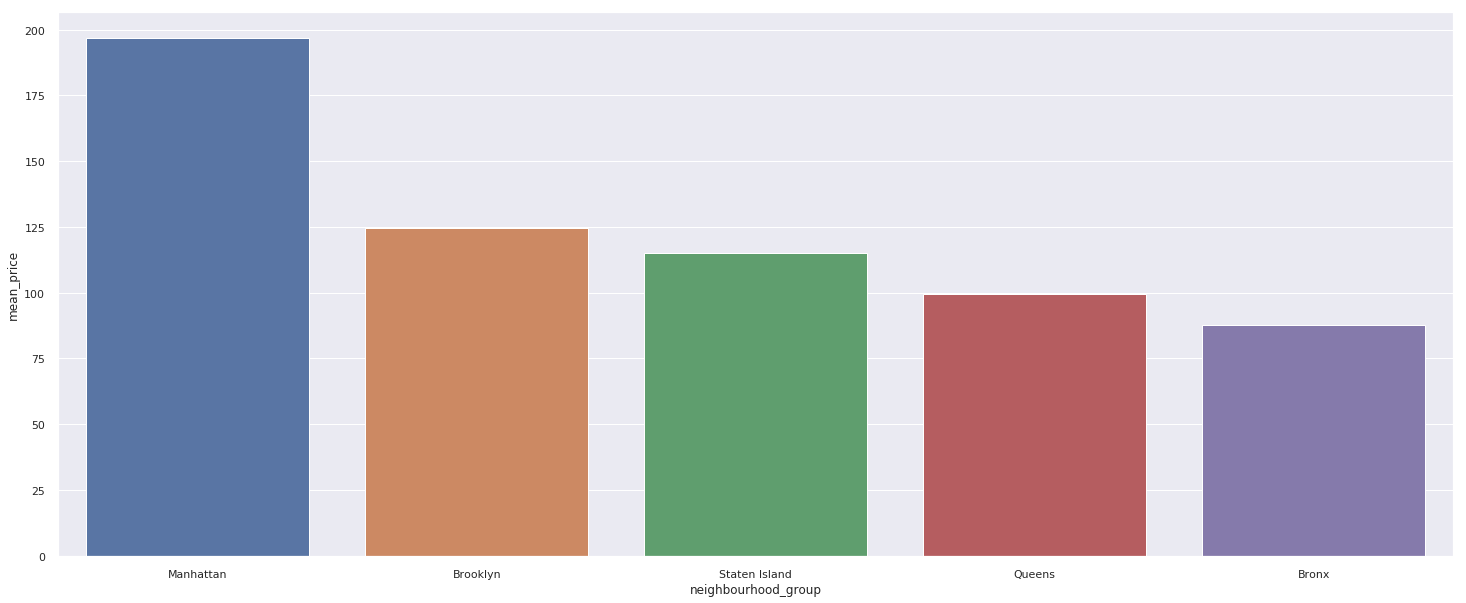

In [19]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood_group", y="mean_price", data=df_neigh_gr_pd)

**Finding out the neighbourhood’s average price so that I am able to pick an economical location to book my hotel.**

In [20]:
#This will calculate mean price of each distinct neighbourhood
df_neigh_pd = df.groupBy('neighbourhood').agg(func.mean("price").alias("mean_price")).orderBy('mean_price', ascending=True).toPandas().head(20)

In [21]:
df_neigh_pd

,neighbourhood,mean_price
0,Bull's Head,47.333333
1,Hunts Point,50.500000
2,Tremont,51.545455
3,Soundview,53.466667
4,New Dorp,57.000000
5,Bronxdale,57.105263
6,New Dorp Beach,57.400000
7,Grant City,57.666667
8,Concord,58.192308
9,Mount Eden,58.500000


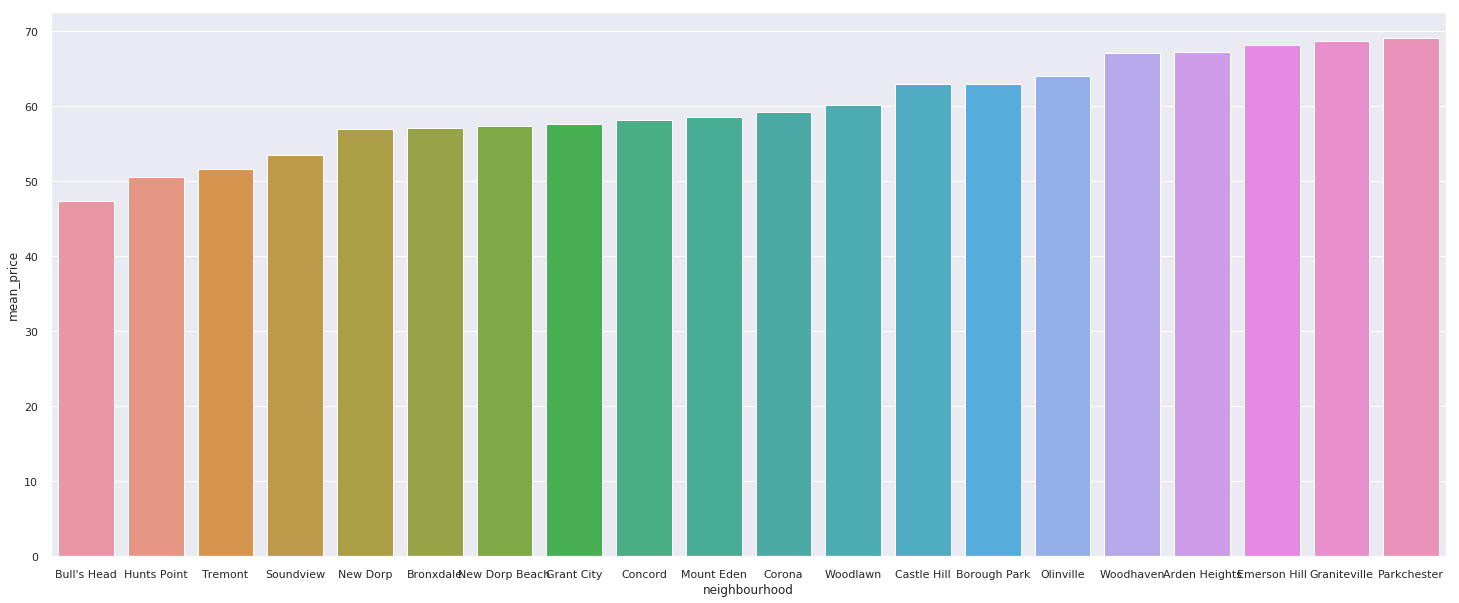

In [22]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood", y="mean_price", data=df_neigh_pd)

* Finding out the 10 most popular hosts based on number_of_reviews
* Creating a column named popularity_index depicting popularity of the host.

In [23]:
#calculaitng sum of reviews for each host_id
df_host_popularity = df.groupby('host_id').agg(func.sum('number_of_reviews').alias('sum_review'))

In [24]:
#calculating total reviews for complete data
total_reviews = df.select(func.sum('number_of_reviews')).head()[0]

In [25]:
total_reviews

1133258

In [26]:
#import udf
from pyspark.sql import udf

In [27]:
import pyspark.sql.functions as F

In [28]:
#Defining function for withcolumn operation and then udf
def func_divide(a1,a2):
  return a1*100.0/float(a2)

In [29]:
divide_func_sp = F.udf(func_divide,FloatType())

In [30]:
divide_func_sp

<function __main__.func_divide(a1, a2)>

In [31]:
#withColumn adds new column and applied the funcition to make new column
df_host_popularity = df_host_popularity.withColumn('total_sum_reviews', F.lit(total_reviews))

In [32]:
df_host_popularity.show()

+--------+----------+-----------------+
| host_id|sum_review|total_sum_reviews|
+--------+----------+-----------------+
|  291112|        35|          1133258|
| 1384111|       103|          1133258|
| 1597481|        13|          1133258|
| 2108853|        18|          1133258|
| 2429432|        27|          1133258|
| 2530670|       134|          1133258|
| 3432742|         2|          1133258|
| 1360296|        13|          1133258|
| 2124690|         1|          1133258|
| 6414252|         1|          1133258|
| 9637768|        47|          1133258|
| 9947836|        87|          1133258|
| 9430366|       159|          1133258|
| 7974574|         5|          1133258|
| 5907325|        32|          1133258|
|13749425|       198|          1133258|
| 5771331|        20|          1133258|
| 9784206|       204|          1133258|
| 4702135|         0|          1133258|
|19239110|        25|          1133258|
+--------+----------+-----------------+
only showing top 20 rows



In [33]:
#creating popularity_index column by diving each host_id reviews by total no. of reviews
df_host_popularity = df_host_popularity.withColumn('popularity_index',divide_func_sp('sum_review','total_sum_reviews'))

In [34]:
df_host_popularity.orderBy('popularity_index', ascending=False).show(10)

+---------+----------+-----------------+----------------+
|  host_id|sum_review|total_sum_reviews|popularity_index|
+---------+----------+-----------------+----------------+
| 37312959|      2273|          1133258|      0.20057216|
|   344035|      2205|          1133258|      0.19457176|
| 26432133|      2017|          1133258|      0.17798242|
| 35524316|      1971|          1133258|      0.17392333|
| 40176101|      1818|          1133258|      0.16042243|
|  4734398|      1798|          1133258|      0.15865761|
| 16677326|      1355|          1133258|      0.11956677|
|  6885157|      1346|          1133258|       0.1187726|
|219517861|      1281|          1133258|      0.11303692|
| 23591164|      1269|          1133258|      0.11197803|
+---------+----------+-----------------+----------------+
only showing top 10 rows



In [35]:
df_host_popularity = df_host_popularity.select('host_id','popularity_index')

In [36]:
df_host_popularity.show()

+--------+----------------+
| host_id|popularity_index|
+--------+----------------+
|  291112|    0.0030884405|
| 1384111|     0.009088839|
| 1597481|     0.001147135|
| 2108853|    0.0015883408|
| 2429432|    0.0023825113|
| 2530670|     0.011824315|
| 3432742|    1.7648232E-4|
| 1360296|     0.001147135|
| 2124690|     8.824116E-5|
| 6414252|     8.824116E-5|
| 9637768|    0.0041473345|
| 9947836|     0.007676981|
| 9430366|     0.014030345|
| 7974574|     4.412058E-4|
| 5907325|    0.0028237172|
|13749425|      0.01747175|
| 5771331|    0.0017648232|
| 9784206|     0.018001197|
| 4702135|             0.0|
|19239110|     0.002206029|
+--------+----------------+
only showing top 20 rows



In [37]:
df_host_popularity.orderBy('popularity_index', ascending=False).show(10)

+---------+----------------+
|  host_id|popularity_index|
+---------+----------------+
| 37312959|      0.20057216|
|   344035|      0.19457176|
| 26432133|      0.17798242|
| 35524316|      0.17392333|
| 40176101|      0.16042243|
|  4734398|      0.15865761|
| 16677326|      0.11956677|
|  6885157|       0.1187726|
|219517861|      0.11303692|
| 23591164|      0.11197803|
+---------+----------------+
only showing top 10 rows



In [38]:
#merging the popularity_index to the main dataframe
df = df.join(df_host_popularity, "host_id", "left")

In [39]:
df.show(2)

+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|host_id|  id|                name|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|
+-------+----+--------------------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+
|   2787|2539|Clean & quiet apt...|     John|           Brooklyn|   Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|     0.009265321|
|   

**Finding out the top locations where people tend to stay for a longer duration (more than a week) and sorting those by their popularity index. **

In [40]:
#spark filter and sorting
df.filter(df['minimum_nights'] > 10).orderBy('popularity_index', ascending=False).select(df['neighbourhood']).show(20)

+------------------+
|     neighbourhood|
+------------------+
|       Murray Hill|
|   Upper East Side|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|    Hell's Kitchen|
|       Murray Hill|
|Financial District|
|       Murray Hill|
|       Murray Hill|
|           Midtown|
|       Murray Hill|
|  Theater District|
|       Murray Hill|
|           Chelsea|
|       Murray Hill|
|  Theater District|
|  Theater District|
+------------------+
only showing top 20 rows



**Finding out the most popular regions based on the host_id’s popularity_index**



In [41]:
df_popular_regions = df.groupby('neighbourhood').agg(func.sum('popularity_index').alias('pop_reg'))

In [42]:
df_popular_regions.show()

+------------------+--------------------+
|     neighbourhood|             pop_reg|
+------------------+--------------------+
|            Corona| 0.37996642736834474|
|      Richmondtown|0.006971051450818777|
|      Prince's Bay|0.002029546711128205|
|       Westerleigh|0.001588340826856438|
|        Mill Basin|0.006088639871450141|
|      Civic Center| 0.09212377076619305|
|        Douglaston|0.021972048794850707|
|        Mount Hope| 0.06353363431117032|
|       Marble Hill|0.016942302339884918|
|         Rego Park|  0.4028208956660819|
|     Dyker Heights| 0.07421081555366982|
| Kew Gardens Hills|   0.037943698487652|
|      Dongan Hills| 0.01817767834290862|
|Financial District|  26.021435049442516|
|       Bay Terrace|0.023030942829791456|
|           Midtown|   6.246238657622598|
|   Jackson Heights|  1.0538641667517368|
|           Bayside| 0.18530643329722807|
|    Hell's Kitchen|  15.653981718765863|
|        Highbridge| 0.35949447581515415|
+------------------+--------------

In [43]:
df_popular_regions = df_popular_regions.orderBy('pop_reg', ascending=False).toPandas().head(10)

In [44]:
df_popular_regions.head()

,neighbourhood,pop_reg
0,Financial District,26.021435
1,Bedford-Stuyvesant,23.885823
2,Hell's Kitchen,15.653982
3,Harlem,12.466005
4,Williamsburg,12.268080


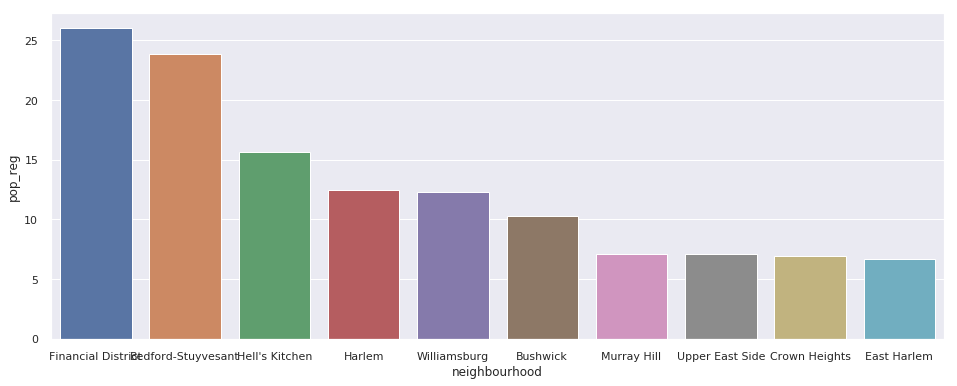

In [45]:
plt.figure(figsize=(16, 6))
sns.barplot(x='neighbourhood', y='pop_reg', data=df_popular_regions)

* Calculating host_id’s popularity in its neighbourhood 
* Creating a column host_neighbourhood_popularity by calculating relative percentage of reviews of host among total reviews in that region.


In [46]:
#Summing no. of reviews for each neighbourhood
df_neighbourhood_sum = df.groupby('neighbourhood').agg(func.sum('number_of_reviews').alias('sum_reviews_ne'))

In [47]:
df_neighbourhood_sum.show(5)

+-------------+--------------+
|neighbourhood|sum_reviews_ne|
+-------------+--------------+
|       Corona|          1806|
| Richmondtown|            79|
| Prince's Bay|            23|
|  Westerleigh|            18|
|   Mill Basin|            69|
+-------------+--------------+
only showing top 5 rows



In [48]:
df_neighbourhood_sum.head()

Row(neighbourhood='Corona', sum_reviews_ne=1806)

In [49]:
df_neighbourhood_host_sum = df.groupby('host_id','neighbourhood').agg(func.sum('number_of_reviews').alias('sum_reviews_id_ne'))

In [50]:
df_neighbourhood_host_sum.show()

+--------+--------------------+-----------------+
| host_id|       neighbourhood|sum_reviews_id_ne|
+--------+--------------------+-----------------+
|  829652|            Gramercy|              105|
| 1269455|        West Village|               37|
| 1498424|         Fort Greene|               35|
| 1633100|            Bushwick|               42|
|  160565|  Bedford-Stuyvesant|                3|
| 4241953|            Flushing|               81|
| 3898812|             Astoria|               58|
| 6873370|         Sunset Park|               24|
|  173980|  Bedford-Stuyvesant|              181|
| 1472225|        East Village|               59|
|11192207|     Upper West Side|                2|
|10930874|        Forest Hills|                1|
|16288928|          Park Slope|              136|
| 9604972|     Lower East Side|                1|
|17604079|              Harlem|                1|
|17773625|             Tribeca|               73|
| 2119276|     Upper East Side|               20|


In [51]:
#merging column
df_neighbourhood_host_merged = df_neighbourhood_host_sum.join(df_neighbourhood_sum,'neighbourhood','left')

In [52]:
df_neighbourhood_host_merged.filter(df['neighbourhood'] == 'Williamsburg').orderBy('host_id', ascending=True).show(10)

+-------------+-------+-----------------+--------------+
|neighbourhood|host_id|sum_reviews_id_ne|sum_reviews_ne|
+-------------+-------+-----------------+--------------+
| Williamsburg|   2438|                1|         85368|
| Williamsburg|  10889|              383|         85368|
| Williamsburg|  15991|              148|         85368|
| Williamsburg|  19402|               37|         85368|
| Williamsburg|  21207|                9|         85368|
| Williamsburg|  21306|                2|         85368|
| Williamsburg|  39304|                0|         85368|
| Williamsburg|  45384|               20|         85368|
| Williamsburg|  51414|                9|         85368|
| Williamsburg|  52043|               53|         85368|
+-------------+-------+-----------------+--------------+
only showing top 10 rows



In [53]:
def func_divide(a1,a2):
  if(a2!=0):
    ans = a1*100.0/float(a2)
  else:
    ans = 0
  return ans

In [54]:
divide_func_sp = F.udf(func_divide,FloatType())

In [55]:
df_neighbourhood_host_merged = df_neighbourhood_host_merged.withColumn('host_neighbourhood_popularity',divide_func_sp('sum_reviews_id_ne','sum_reviews_ne'))

In [56]:
df_neighbourhood_host_merged.show()

+-------------+---------+-----------------+--------------+-----------------------------+
|neighbourhood|  host_id|sum_reviews_id_ne|sum_reviews_ne|host_neighbourhood_popularity|
+-------------+---------+-----------------+--------------+-----------------------------+
|       Corona|265288059|                7|          1806|                    0.3875969|
|       Corona|176679165|              156|          1806|                     8.637874|
|       Corona| 32446721|              100|          1806|                    5.5370984|
|       Corona|124042625|                4|          1806|                   0.22148395|
|       Corona| 44620317|              114|          1806|                    6.3122926|
|       Corona| 34129674|                0|          1806|                          0.0|
|       Corona|  5261297|               45|          1806|                    2.4916945|
|       Corona| 98697139|               43|          1806|                    2.3809524|
|       Corona| 31307

In [57]:
df_neighbourhood_host_merged.orderBy('host_neighbourhood_popularity', ascending=False).show(20)

+---------------+---------+-----------------+--------------+-----------------------------+
|  neighbourhood|  host_id|sum_reviews_id_ne|sum_reviews_ne|host_neighbourhood_popularity|
+---------------+---------+-----------------+--------------+-----------------------------+
|   Breezy Point|200754542|                5|             5|                        100.0|
|    Eastchester|   310670|              157|           157|                        100.0|
|      Rossville|  6402171|               21|            21|                        100.0|
|    Eltingville| 28189446|               83|            83|                        100.0|
|   Richmondtown| 71312760|               79|            79|                        100.0|
|    Willowbrook|115827173|                9|             9|                        100.0|
|    Westerleigh|164164069|               17|            18|                     94.44444|
|     Co-op City|   310670|               32|            34|                    94.117645|

In [58]:
df_neighbourhood_host_merged = df_neighbourhood_host_merged.select('host_id','neighbourhood','host_neighbourhood_popularity')

In [59]:
df_neighbourhood_host_merged.show(5)

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|265288059|       Corona|                    0.3875969|
|176679165|       Corona|                     8.637874|
| 32446721|       Corona|                    5.5370984|
|124042625|       Corona|                   0.22148395|
| 44620317|       Corona|                    6.3122926|
+---------+-------------+-----------------------------+
only showing top 5 rows



In [60]:
#To validate results, for baychester the sum of all the host_neighbourhood_popularity = 100.0
df_neighbourhood_host_merged.filter(df_neighbourhood_host_merged['neighbourhood']=='Baychester').show()

+---------+-------------+-----------------------------+
|  host_id|neighbourhood|host_neighbourhood_popularity|
+---------+-------------+-----------------------------+
|209306758|   Baychester|                     6.774194|
| 64425305|   Baychester|                    0.9677419|
|246653349|   Baychester|                     3.548387|
|129890157|   Baychester|                          0.0|
| 57165692|   Baychester|                     88.70968|
+---------+-------------+-----------------------------+



In [61]:
df = df.join(df_neighbourhood_host_merged,['host_id','neighbourhood'],'left')

In [62]:
df.filter(df['host_neighbourhood_popularity']>90).show(2)

+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| host_id|neighbourhood|      id|                name|host_name|neighbourhood_group|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|
+--------+-------------+--------+--------------------+---------+-------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+
| 6402171|    Rossville|26258351|Escape NYC in the...|    Taryn|      Staten Island| 40.5479|-74.21017|Entire home/apt|   75|             3|        

**Finding:**
* Maximum revenue in Private Rooms 
* Minimum revenue in Private Rooms 
* Maximum revenue in Entire Homes 
* Minimum revenue in Entire Homes 


In [63]:
#Filtering only private room and entire room
df_neighbourhood_room_type = df.filter(df['room_type'] != 'Shared room')

In [64]:
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood','room_type').agg(func.sum('price').alias('price_sum'))

In [65]:
df_neighbourhood_room_type.show()

+-----------------+---------------+---------+
|    neighbourhood|      room_type|price_sum|
+-----------------+---------------+---------+
|Battery Park City|Entire home/apt|    23450|
|   Morris Heights|Entire home/apt|      421|
|     Coney Island|   Private room|      480|
|Battery Park City|   Private room|     2224|
|        Unionport|   Private room|      225|
|   Williamsbridge|Entire home/apt|     2818|
|          Arverne|   Private room|     2369|
|       Morrisania|   Private room|      623|
|       Kensington|   Private room|     5819|
|    Schuylerville|   Private room|      624|
|             NoHo|Entire home/apt|    21474|
|      Murray Hill|   Private room|    10335|
|        Laurelton|   Private room|      552|
|         Glendale|Entire home/apt|     3420|
|      Boerum Hill|Entire home/apt|    27624|
|       Ozone Park|Entire home/apt|     3649|
|     Williamsburg|   Private room|   170841|
|  Upper West Side|Entire home/apt|   328724|
|  East Morrisania|   Private room

In [66]:
#pivot operation 
df_neighbourhood_room_type = df_neighbourhood_room_type.groupby('neighbourhood').pivot('room_type').sum('price_sum')

In [67]:
df_neighbourhood_room_type.show()

+------------------+---------------+------------+
|     neighbourhood|Entire home/apt|Private room|
+------------------+---------------+------------+
|            Corona|           1549|        1485|
|      Prince's Bay|           1520|         118|
|      Richmondtown|             78|        null|
|        Mill Basin|            719|        null|
|       Westerleigh|            103|          40|
|      Civic Center|           7925|        2056|
|        Douglaston|            402|         215|
|        Mount Hope|           1079|         471|
|       Marble Hill|            459|         611|
|         Rego Park|           5085|        3486|
|     Dyker Heights|            804|         278|
| Kew Gardens Hills|           2052|         868|
|      Dongan Hills|            405|         151|
|       Bay Terrace|            631|         189|
|Financial District|         138853|       26831|
|           Bayside|           4616|        1544|
|   Jackson Heights|           7232|        7137|


In [68]:
#Maximum revenue in Private Rooms
df_neighbourhood_room_type.orderBy('Private room', ascending=False).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row



In [69]:
df_min = df_neighbourhood_room_type.orderBy('Private room', ascending=True)

In [70]:
#Minimum revenue in Private Rooms after filetering out null values
df_min[df_min['Private room'].isNotNull()].show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Graniteville|            186|          20|
+-------------+---------------+------------+
only showing top 1 row



In [71]:
##minimum revenue in Entire home/apt Rooms
df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=True).filter(df_neighbourhood_room_type['Entire home/apt'].isNotNull()).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
|     New Dorp|             57|        null|
+-------------+---------------+------------+
only showing top 1 row



In [72]:
###maximum revenue in Entire home/apt Rooms

df_neighbourhood_room_type.orderBy('Entire home/apt', ascending=False).show(1)

+-------------+---------------+------------+
|neighbourhood|Entire home/apt|Private room|
+-------------+---------------+------------+
| Williamsburg|         389426|      170841|
+-------------+---------------+------------+
only showing top 1 row



**Calculating the average price income for private rooms and entire homes for each of the neighbourhoods
**

In [73]:
df_neighbourhood_room_type_mean = df.filter(df['room_type'] != 'Shared room')

In [74]:
df_neighbourhood_room_type_mean = df_neighbourhood_room_type_mean.groupby('neighbourhood','room_type').agg(func.mean('price').alias('average_region_price'))

In [75]:
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean.groupby('neighbourhood').pivot('room_type').sum('average_region_price')

In [76]:
df_neighbourhood_room_type_mean_pivot.show()

+------------------+------------------+------------------+
|     neighbourhood|   Entire home/apt|      Private room|
+------------------+------------------+------------------+
|            Corona|119.15384615384616|              55.0|
|      Prince's Bay| 506.6666666666667|             118.0|
|      Richmondtown|              78.0|              null|
|        Mill Basin|            179.75|              null|
|       Westerleigh|             103.0|              40.0|
|      Civic Center|226.42857142857142|120.94117647058823|
|        Douglaston|             134.0|             53.75|
|        Mount Hope|             107.9|              47.1|
|       Marble Hill|              91.8| 87.28571428571429|
|         Rego Park|           127.125| 59.08474576271186|
|     Dyker Heights|114.85714285714286|              69.5|
| Kew Gardens Hills|120.70588235294117| 96.44444444444444|
|      Dongan Hills|            101.25|50.333333333333336|
|       Bay Terrace|210.33333333333334|              94.

In [77]:
df_neighbourhood_room_type_mean_pivot = df_neighbourhood_room_type_mean_pivot.toPandas()

<Figure size 2160x720 with 0 Axes>

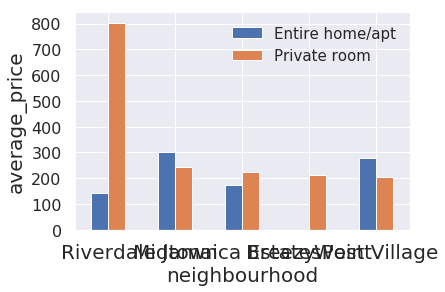

In [78]:
#Plotting 
plt.figure(figsize=(30, 10))
labels = []
import matplotlib.pyplot as plt
ax=df_neighbourhood_room_type_mean_pivot.sort_values('Private room', ascending=False).head().plot(kind='bar', width = 0.5)
ax.set_xlabel('neighbourhood', fontsize = 20)
ax.set_ylabel('average_price', fontsize = 20)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
a = [item.get_text() for item in ax.get_xticklabels()]  #to get labels as they are coming as index
for i in a:
  labels.append(df_neighbourhood_room_type_mean_pivot['neighbourhood'][int(i)])
ax.set_xticklabels(labels)  #setting xticks as neighbourhood name
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
    tick.label.set_rotation('horizontal')
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)     
plt.rcParams["figure.figsize"] = fig_size
plt.legend(prop={'size':'15'})
plt.show(ax)

**Creating a column depicting relative price difference of that host with respect to the neighbourhood’s average pricing.**


In [79]:
df = df.join(df_neighbourhood_room_type_mean,['neighbourhood','room_type'],'left')

In [80]:
df.filter(df['neighbourhood'] == 'Kensington').show()

+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|neighbourhood|   room_type|  host_id|      id|                name|host_name|neighbourhood_group|latitude|longitude|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|average_region_price|
+-------------+------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+
|   Kensington|Private room|  6755111| 1239293|Cozy Retreat in B...|  Jessica|           Br

In [81]:
#Filtering out null values for price
temp1 = df.filter(df['price'].isNotNull())

In [82]:
#Filtering out null values for average_region_price
temp1 = temp1.filter(temp1['average_region_price'].isNotNull())

In [83]:
#Defining function and converting it to udf function for with column operation
def func_divide1(a1,a2):
  if(type(a1)=='NoneType' or type(a2)=='NoneType'):
    ans = 0
  elif(a1!=0):
    ans = ((a1-a2)*100.0)/float(a1)
  else:
    ans = 0
  return ans

divide_func_sp1 = F.udf(func_divide1,FloatType())

In [84]:
#withcolumn operation
df = temp1.withColumn('region_price_margin',divide_func_sp1('price','average_region_price'))

In [85]:
df.show(1)

+-----------------+---------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+-------------------+
|    neighbourhood|      room_type|  host_id|      id|                name|host_name|neighbourhood_group|latitude|longitude|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|popularity_index|host_neighbourhood_popularity|average_region_price|region_price_margin|
+-----------------+---------------+---------+--------+--------------------+---------+-------------------+--------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+----------------+-----------------------------+--------------------+-------------------+
|Battery P